In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pm = "\u00B1"
MEDIUM_SIZE = 11
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

base_font = {'family': 'serif',
        'size': MEDIUM_SIZE,
        }

title_font = {
  'fontsize' : BIGGER_SIZE, 
  'font' : 'serif', 
  'weight' : 'bold'
}

In [79]:
DATASETS = []
DATE = '2024-11-12'
directory = Path(DATE)

B_vals = (8, 10, 12, 14) # A
D_vals = (1036, 1039, 1042, 1045) # MHz

for B in B_vals:
  for D in D_vals:
    file_list = list(directory.glob(f"B={B}_D={D}_*.csv"))
    df = pd.read_csv(file_list[0])
    DATASETS.append(df)

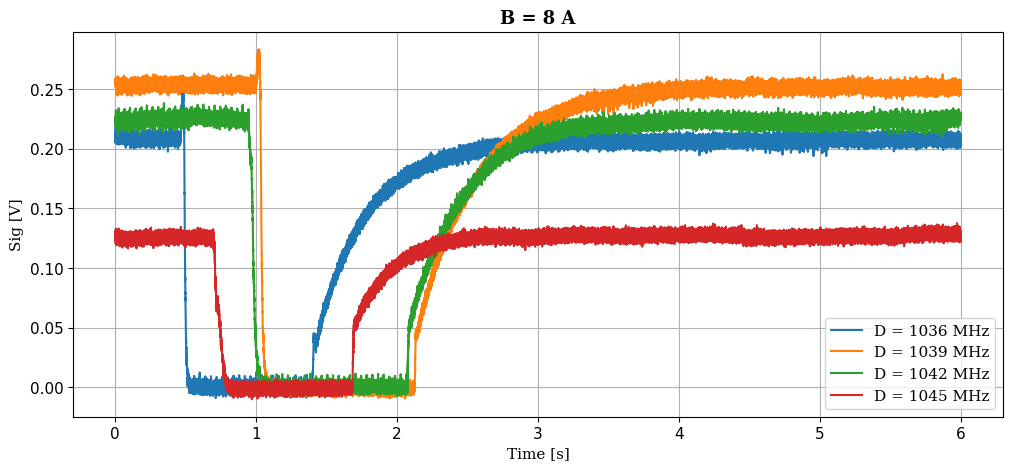

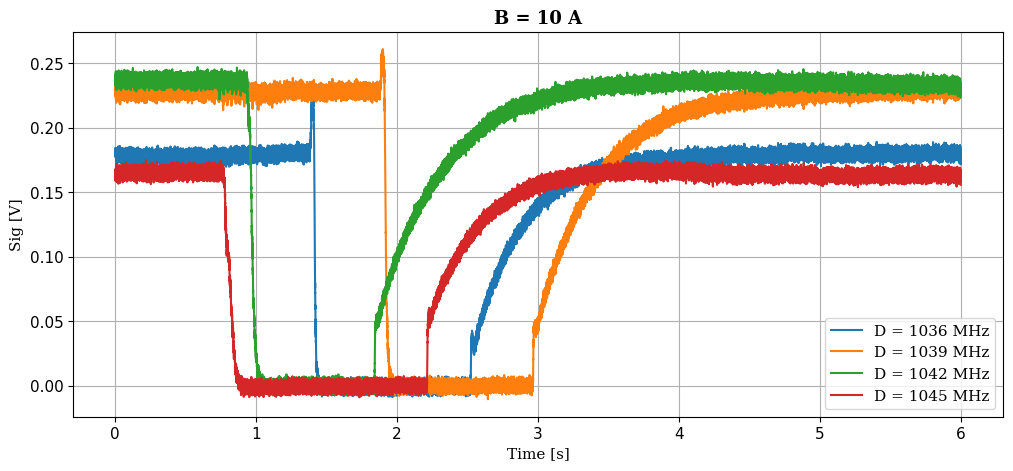

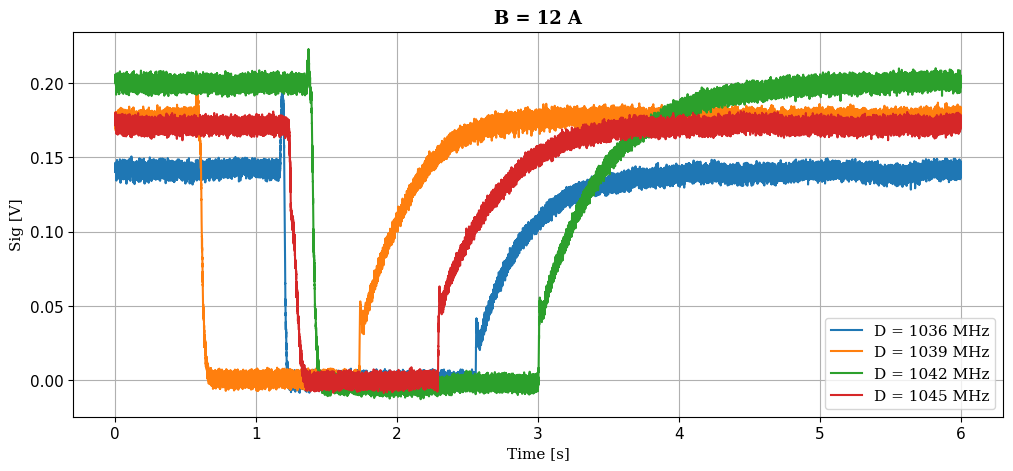

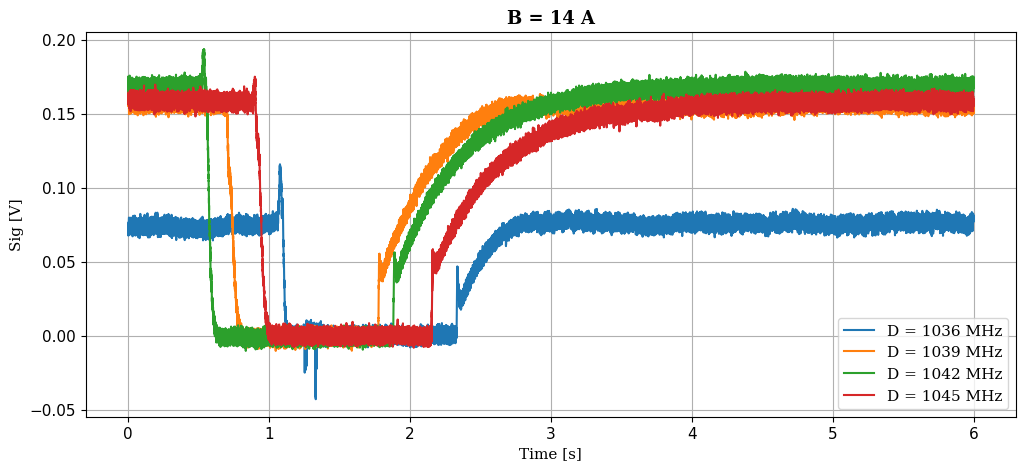

In [102]:
i = 0
DATA_FOR_FIT =[]

for B in B_vals:
  _, ax = plt.subplots(1, 1, figsize=(12, 5))
  ax.set_title(f'B = {B} A', fontdict=title_font)
  for D in D_vals:
    df = DATASETS[i]
    i += 1
    x_data = df['Time [s]'].to_numpy()
    y_data = df['Sig [V]'].to_numpy()
    if B != 12 or D != 1036:
      y_data = y_data - np.mean(y_data[-100:])
    else:
      index_mean = (x_data < 2.4) * (x_data > 1.6)
      y_data = y_data - np.mean(y_data[index_mean])
      
    DATA_FOR_FIT.append((x_data, y_data))
    
    N = len(x_data)
    ax.plot(x_data[:N//2], y_data[:N//2], label=f'D = {D} MHz')
    ax.set_xlabel('Time [s]', fontdict=base_font)
    ax.set_ylabel('Sig [V]', fontdict=base_font)
  
  plt.legend(prop=base_font)
  plt.grid()
  plt.show()
    

In [103]:
from scipy.optimize import curve_fit

COOLER_MOT_FREQ = 1042# MHz
COOLER_RES_FREQ = 1027# MHz
GAMMA = 5.88 # MHz

DEFAULT_VOLTAGE_RANGE = 0.5 # V
DEFAULT_TIME_RANGE = 10 # s

def charge_MOT(t, V0, tau):
    return V0 * (1 - np.exp(-t/tau))
 
def fit_data(data, start_time_fit, end_time_fit):
  """Fit the data from the oscilloscope with an exponential and plot the result."""
  x_data = data[0]
  y_data = data[1]
  
  # Select data for fitting based on start time
  index_fit = (x_data > start_time_fit) * (x_data < end_time_fit)
  x_data_fit = x_data[index_fit] - start_time_fit
  y_data_fit = y_data[index_fit]
  
  # Define initial parameter guesses
  sat_guess = np.mean(y_data_fit)
  tau_guess = 2  # s
  
  # Perform curve fitting with initial guesses
  p0 = [sat_guess, tau_guess]
  popt, pcov = curve_fit(charge_MOT, x_data_fit, y_data_fit, p0=p0)
  V0, tau = popt
  dV0, dtau = np.sqrt(np.diag(pcov))  # Uncertainties in fit parameters
  
  vc = V0 / tau # V / s
  dvc = (dV0/V0 + dtau/tau) * vc
  
  fit_errors = np.sqrt(np.diag(pcov))
  
  print(f'\n V0 = ({V0:.4f} {pm} {dV0:.4f}) V \n tau = ({tau:.4f} {pm} {dtau:.4f}) s \n velocity capture = {vc:.4f} {pm} {dvc:.4f} V/s \n')
  
  # Generate fitted curve data
  x_fit = x_data_fit + start_time_fit  # Shift back to original time axis
  y_fit = charge_MOT(x_data_fit, *popt)
  
  _, ax = plt.subplots(1,1, figsize = (11, 5))
  ax.plot(x_data, y_data, label='Data', color='royalblue')
  ax.plot(x_fit, y_fit, label='Fit', color='crimson')
  ax.set_xlabel('Time [s]', fontdict=base_font)
  ax.set_ylabel('Sig [V]', fontdict=base_font)
  plt.grid()
  plt.legend()
  plt.show()
  
  return popt
  

# Generate Table with fit parameters for all the measurements

In [149]:
dict_params = {
  'V0 [V]': [],
  'tau [s]': [],
  'Vc [V/s]': []
}

## B = 8 A

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1036 MHz

 V0 = (0.2072 ± 0.0000) V 
 tau = (0.3655 ± 0.0002) s 
 velocity capture = 0.5669 ± 0.0004 V/s 



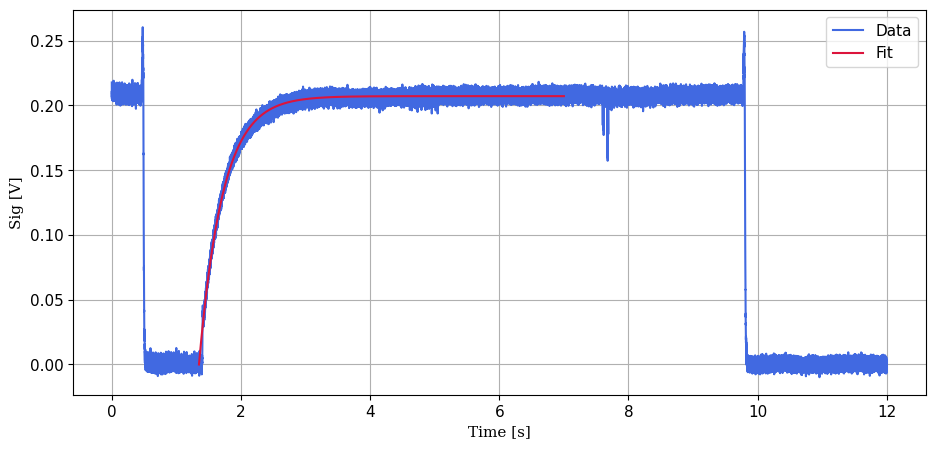

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1039 MHz

 V0 = (0.2519 ± 0.0000) V 
 tau = (0.4397 ± 0.0002) s 
 velocity capture = 0.5729 ± 0.0004 V/s 



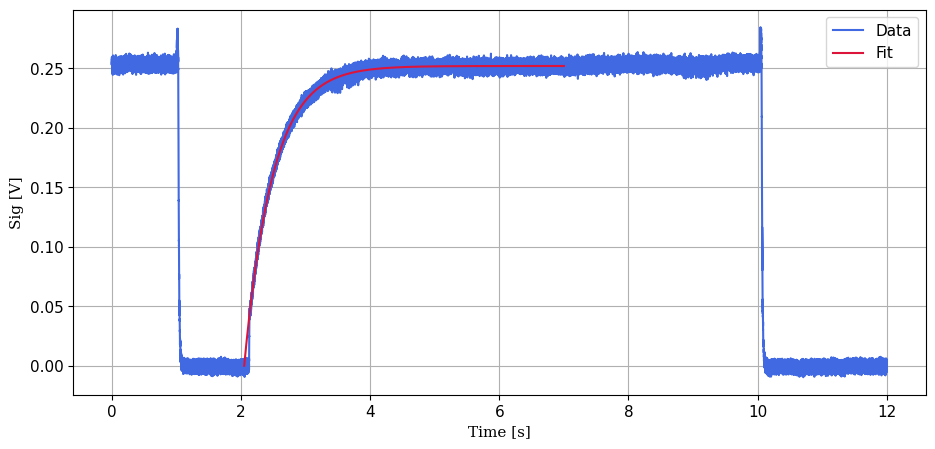

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1042 MHz

 V0 = (0.2235 ± 0.0000) V 
 tau = (0.3690 ± 0.0003) s 
 velocity capture = 0.6058 ± 0.0005 V/s 



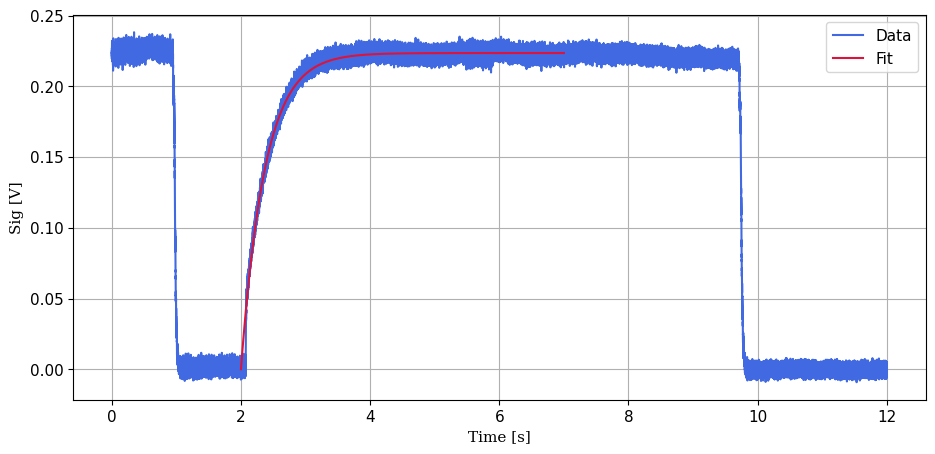

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1045 MHz

 V0 = (0.1277 ± 0.0000) V 
 tau = (0.2430 ± 0.0003) s 
 velocity capture = 0.5254 ± 0.0008 V/s 



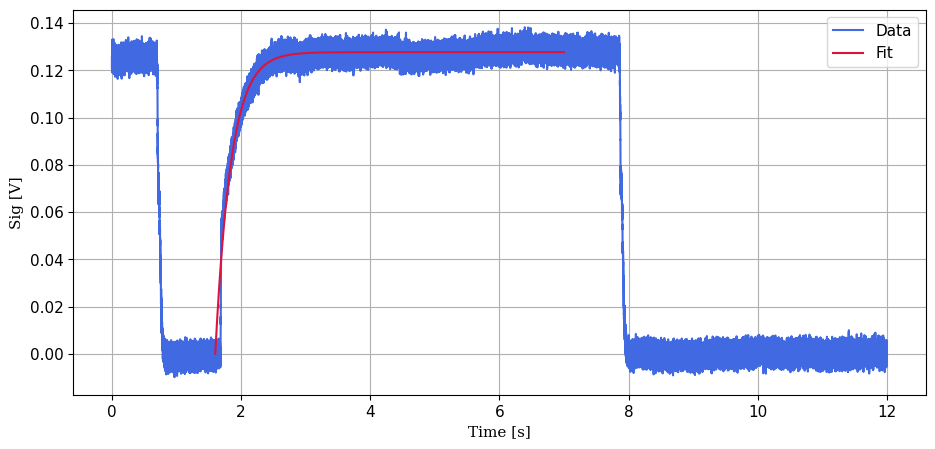

In [150]:
df_8_1036 = DATA_FOR_FIT[0]
df_8_1039 = DATA_FOR_FIT[1]
df_8_1042 = DATA_FOR_FIT[2]
df_8_1045 = DATA_FOR_FIT[3]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_8_1036, df_8_1039, df_8_1042, df_8_1045]
initial_times = [1.35, 2.05, 2.0, 1.6]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 8 A,   DETUNING = {det} MHz')
  V0, tau = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)


---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1036 MHz

 V0 = (0.1795 ± 0.0000) V 
 tau = (0.3303 ± 0.0002) s 
 velocity capture = 0.5436 ± 0.0004 V/s 



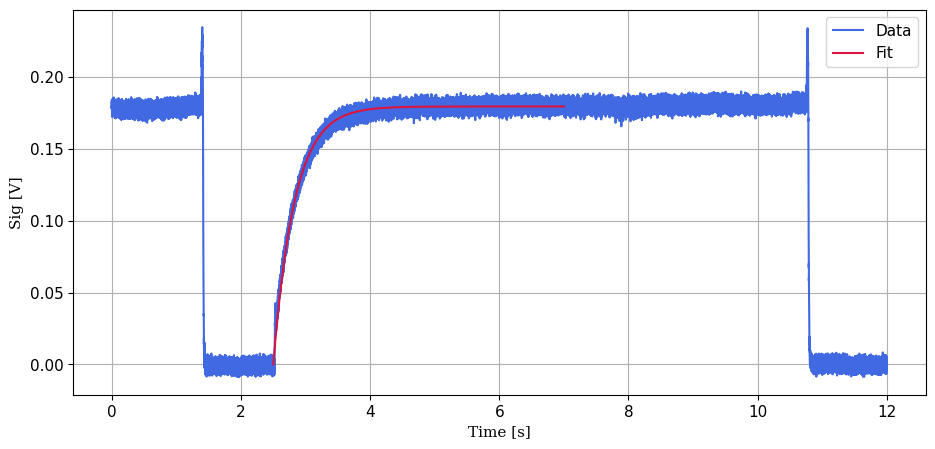

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1039 MHz

 V0 = (0.2280 ± 0.0000) V 
 tau = (0.4277 ± 0.0003) s 
 velocity capture = 0.5330 ± 0.0004 V/s 



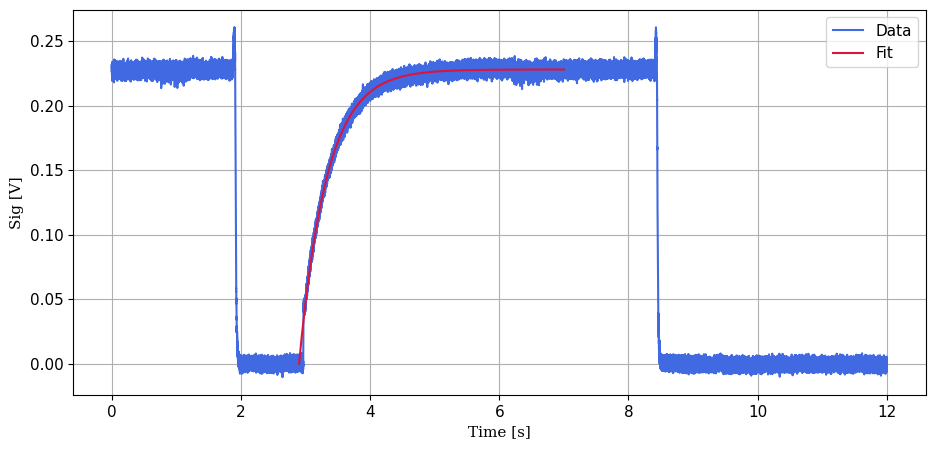

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1042 MHz

 V0 = (0.2346 ± 0.0000) V 
 tau = (0.4023 ± 0.0003) s 
 velocity capture = 0.5832 ± 0.0004 V/s 



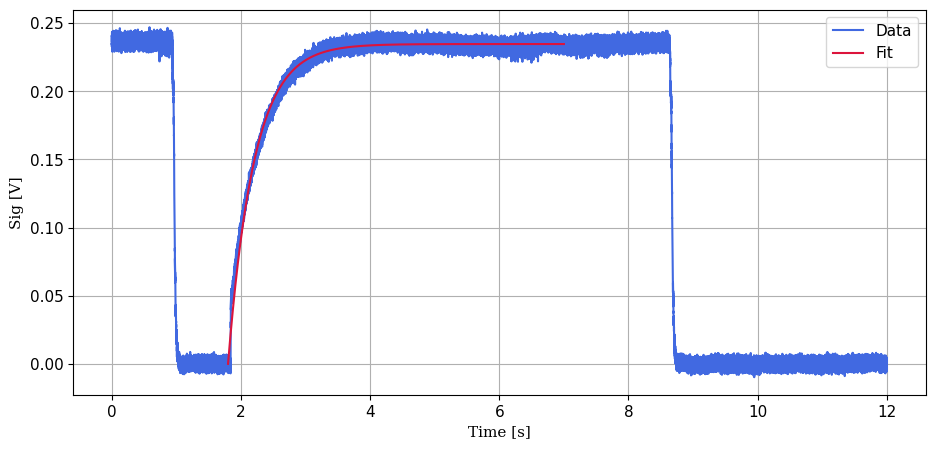

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1045 MHz

 V0 = (0.1650 ± 0.0000) V 
 tau = (0.3479 ± 0.0004) s 
 velocity capture = 0.4743 ± 0.0006 V/s 



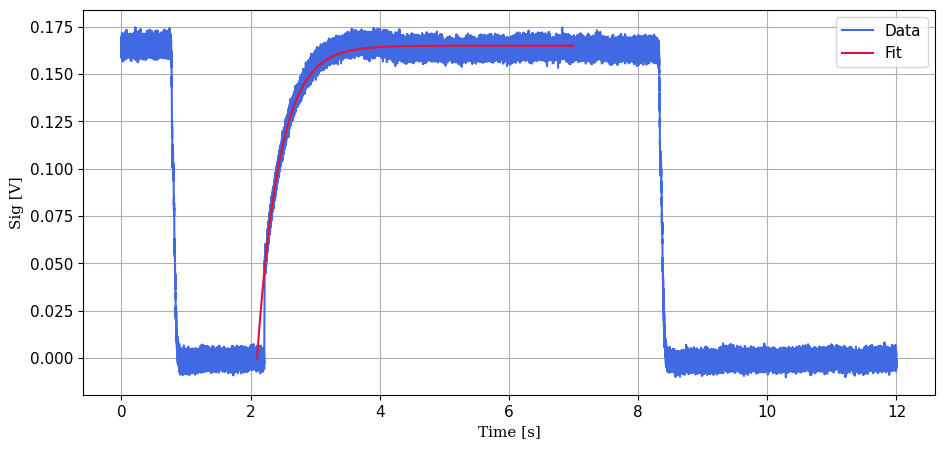

In [151]:
df_10_1036 = DATA_FOR_FIT[4]
df_10_1039 = DATA_FOR_FIT[5]
df_10_1042 = DATA_FOR_FIT[6]
df_10_1045 = DATA_FOR_FIT[7]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_10_1036, df_10_1039, df_10_1042, df_10_1045]
initial_times = [2.5, 2.9, 1.8, 2.1]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 10 A,   DETUNING = {det} MHz')
  V0, tau = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1036 MHz

 V0 = (0.1405 ± 0.0000) V 
 tau = (0.3496 ± 0.0003) s 
 velocity capture = 0.4019 ± 0.0004 V/s 



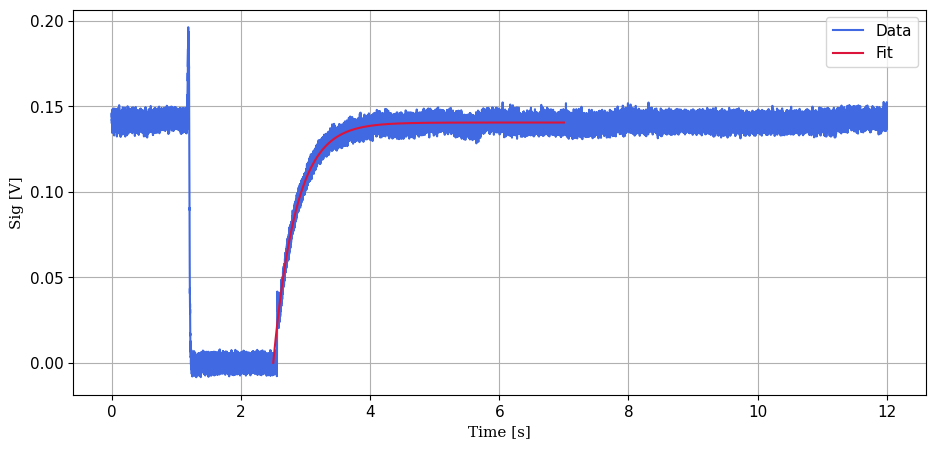

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1039 MHz

 V0 = (0.1781 ± 0.0000) V 
 tau = (0.3415 ± 0.0003) s 
 velocity capture = 0.5216 ± 0.0005 V/s 



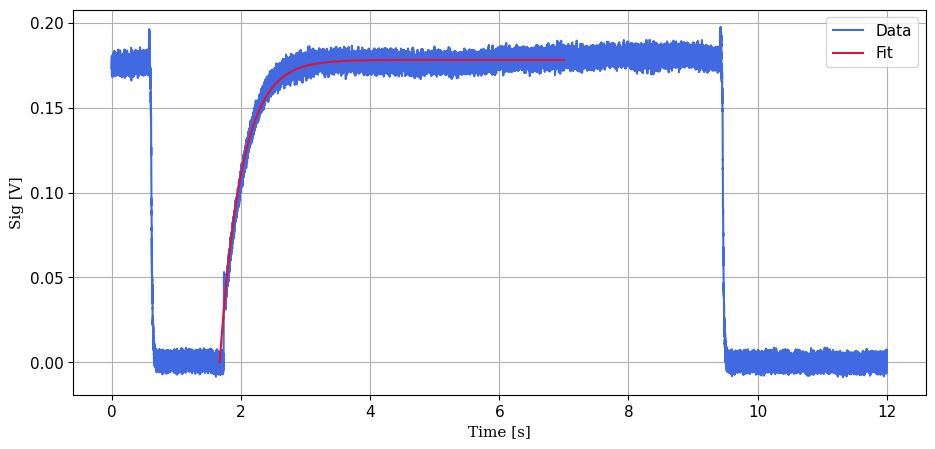

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1042 MHz

 V0 = (0.2016 ± 0.0000) V 
 tau = (0.4755 ± 0.0004) s 
 velocity capture = 0.4240 ± 0.0004 V/s 



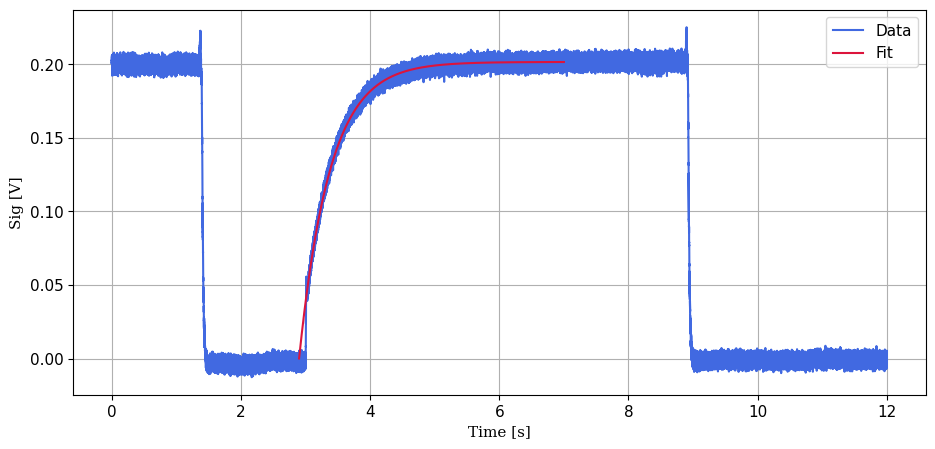

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1045 MHz

 V0 = (0.1724 ± 0.0000) V 
 tau = (0.3827 ± 0.0003) s 
 velocity capture = 0.4503 ± 0.0005 V/s 



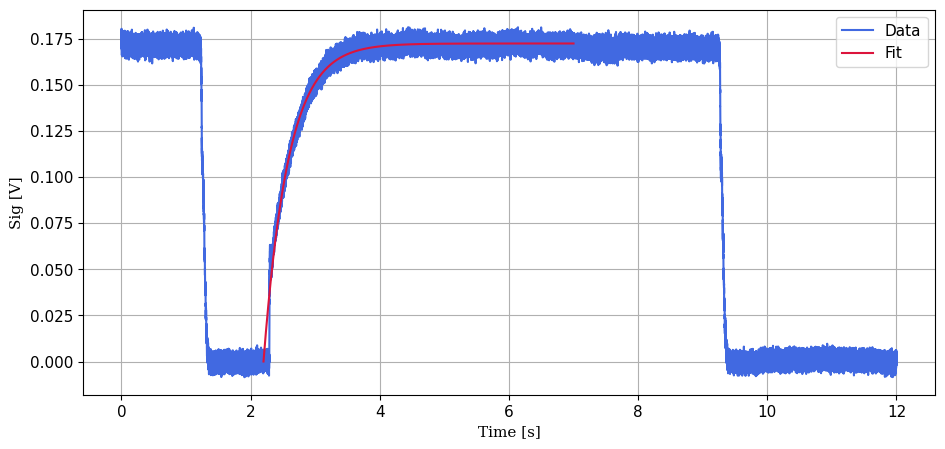

In [152]:
df_12_1036 = DATA_FOR_FIT[8]
df_12_1039 = DATA_FOR_FIT[9]
df_12_1042 = DATA_FOR_FIT[10]
df_12_1045 = DATA_FOR_FIT[11]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_12_1036, df_12_1039, df_12_1042, df_12_1045]
initial_times = [2.5, 1.67, 2.9, 2.2]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 12 A,   DETUNING = {det} MHz')
  V0, tau = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1036 MHz

 V0 = (0.0765 ± 0.0000) V 
 tau = (0.1669 ± 0.0004) s 
 velocity capture = 0.4582 ± 0.0011 V/s 



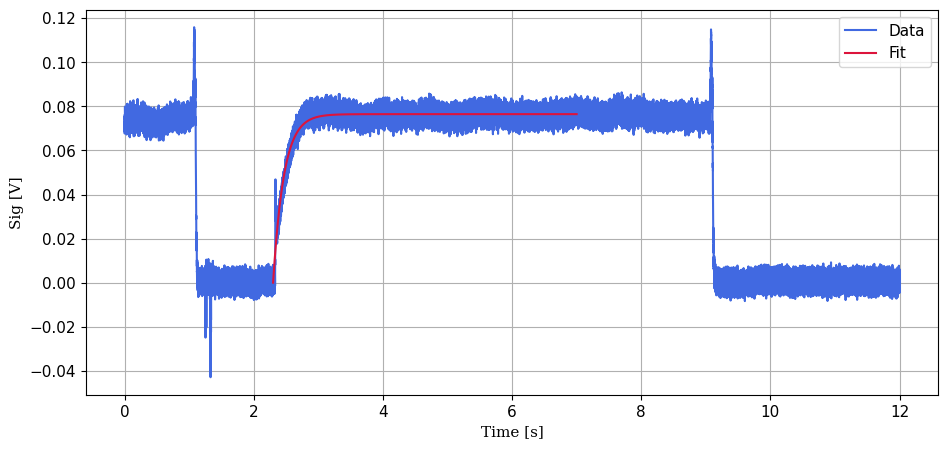

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1039 MHz

 V0 = (0.1569 ± 0.0000) V 
 tau = (0.3302 ± 0.0003) s 
 velocity capture = 0.4752 ± 0.0005 V/s 



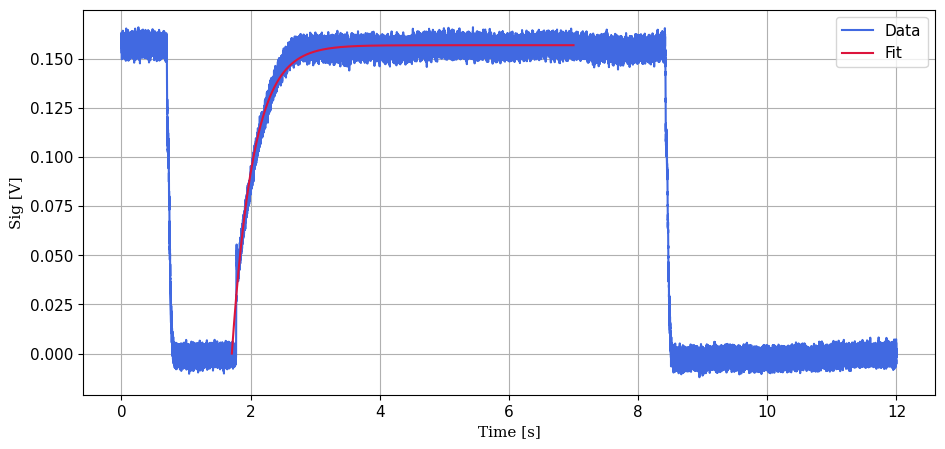

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1042 MHz

 V0 = (0.1688 ± 0.0000) V 
 tau = (0.4416 ± 0.0003) s 
 velocity capture = 0.3822 ± 0.0003 V/s 



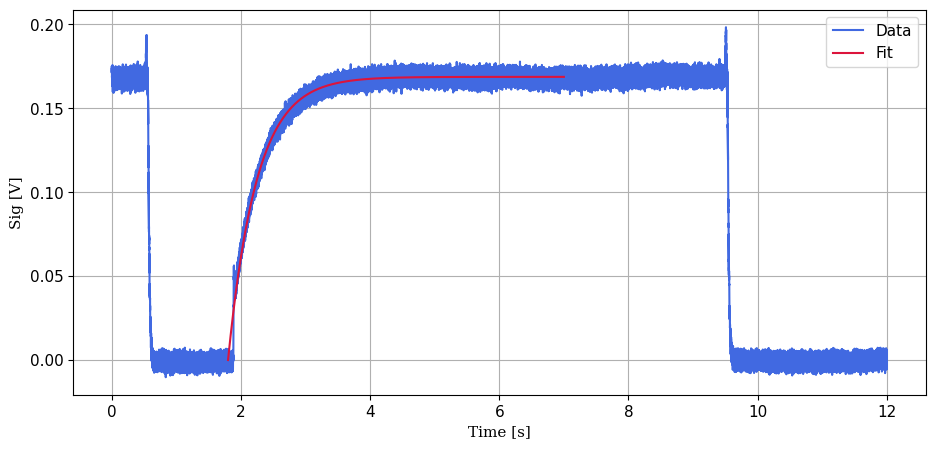

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1045 MHz

 V0 = (0.1589 ± 0.0000) V 
 tau = (0.5113 ± 0.0006) s 
 velocity capture = 0.3107 ± 0.0004 V/s 



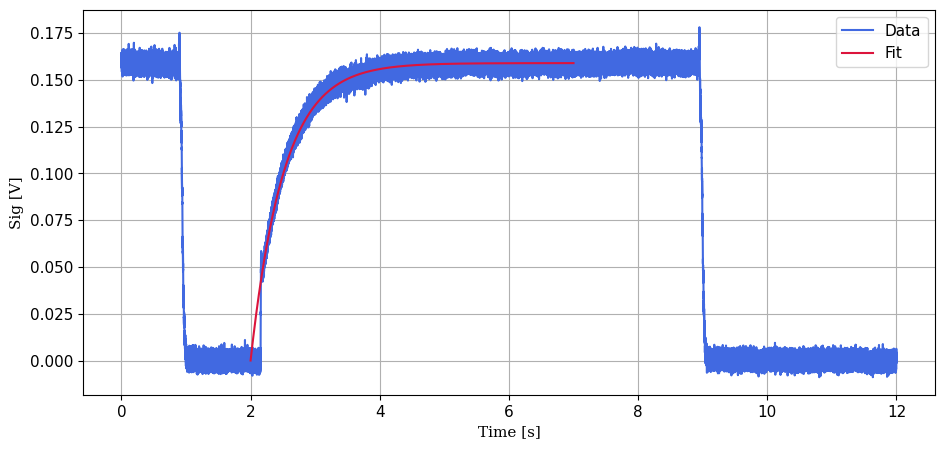

In [153]:
df_14_1036 = DATA_FOR_FIT[12]
df_14_1039 = DATA_FOR_FIT[13]
df_14_1042 = DATA_FOR_FIT[14]
df_14_1045 = DATA_FOR_FIT[15]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_14_1036, df_14_1039, df_14_1042, df_14_1045]
initial_times = [2.3, 1.71, 1.8, 2.0]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 14 A,   DETUNING = {det} MHz')
  V0, tau = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)

In [154]:
index_names = []
for B in B_vals:
  for D in D_vals:
    index_names.append(f'B={B},D={D}')

params_df=pd.DataFrame(dict_params,index=index_names)
params_df

,V0 [V],tau [s],Vc [V/s]
"B=8,D=1036",0.207200,0.365505,0.566886
"B=8,D=1039",0.251895,0.439703,0.572875
"B=8,D=1042",0.223503,0.368960,0.605765
"B=8,D=1045",0.127687,0.243036,0.525382
"B=10,D=1036",0.179521,0.330261,0.543574
"B=10,D=1039",0.228007,0.427743,0.533046
"B=10,D=1042",0.234623,0.402284,0.583229
"B=10,D=1045",0.164983,0.347859,0.474282
"B=12,D=1036",0.140525,0.349611,0.401947
"B=12,D=1039",0.178100,0.341467,0.521574


In [155]:
color_palette = plt.cm.jet(np.linspace(0.68, 1, len(B_vals)))

## Plot V0 trend with D at different B

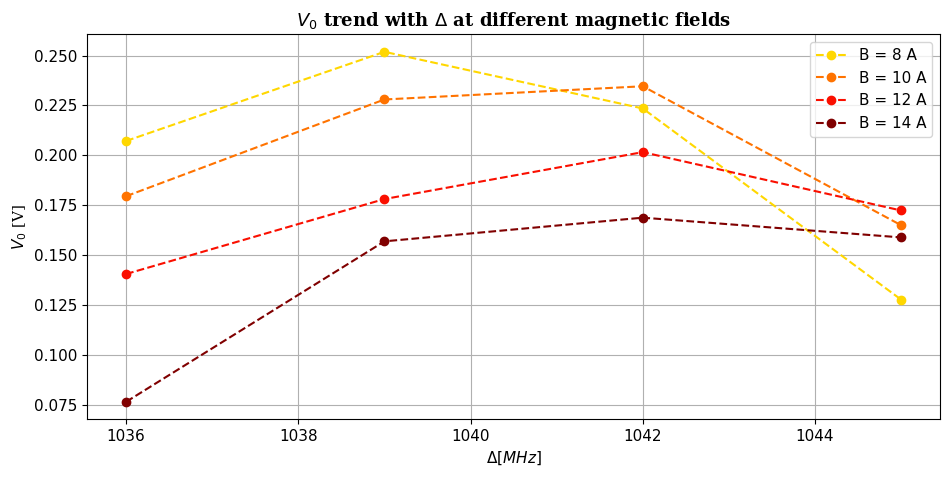

In [156]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$V_0$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  V0_vals = []
  for j, D in enumerate(D_vals):
    V0_vals.append(params_df['V0 [V]'][f'B={B},D={D}'])
  
  y_data = np.array(V0_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$V_0$ [V]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()

## Plot tau trend with D at different B

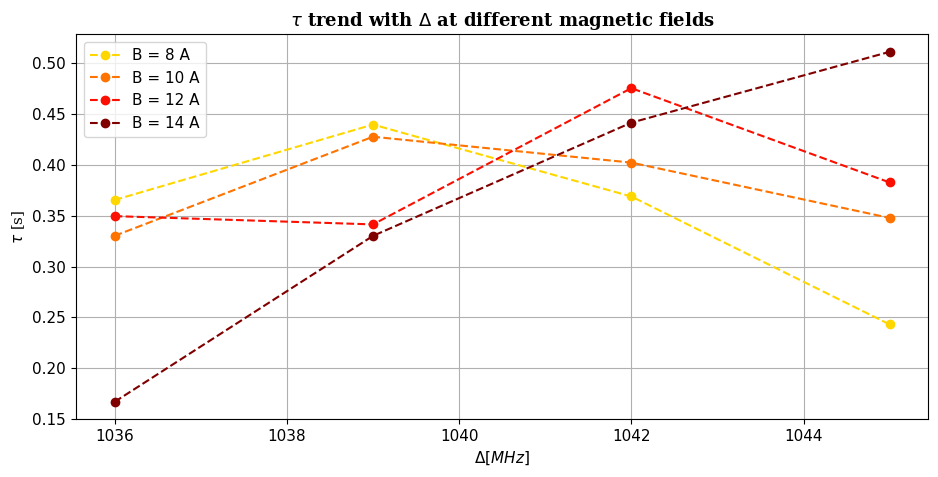

In [157]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$\tau$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  tau_vals = []
  for j, D in enumerate(D_vals):
    tau_vals.append(params_df['tau [s]'][f'B={B},D={D}'])
  
  y_data = np.array(tau_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$\tau$ [s]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()

## Plot Vc trend with D at different B

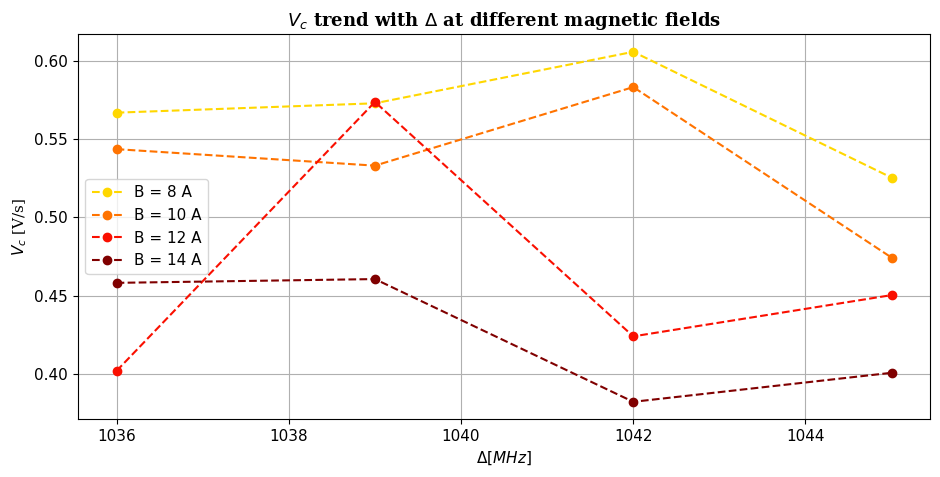

In [121]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$V_c$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  Vc_vals = []
  for j, D in enumerate(D_vals):
    Vc_vals.append(params_df['Vc [V/s]'][f'B={B},D={D}'])
  
  y_data = np.array(Vc_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$V_c$ [V/s]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()